<a href="https://colab.research.google.com/github/appleeye007/scalable_pink_team/blob/main/focus_Resnet14_Fitnets_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math,os,pickle,torch,time
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets,transforms
import torchvision
import torchvision.models as models
import torch.utils.data
import numpy as np
import matplotlib.pyplot as plt
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
import cv2
torch.manual_seed(0)
torch.cuda.manual_seed(0)

In [ ]:
import torch.nn as nn
import torch

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, num_blocks, final_channels, num_classes=10):
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(64, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(128, final_channels, num_blocks[2], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(final_channels, num_classes)

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        layers = [BasicBlock(in_channels, out_channels, stride, downsample)]
        for _ in range(1, num_blocks):
            layers.append(BasicBlock(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        f1 = self.layer1(x)
        f2 = self.layer2(f1)
        f3 = self.layer3(f2)

        pooled = self.avgpool(f3)
        layer_preLogits = torch.flatten(pooled, 1)
        logits = self.fc(layer_preLogits)

        return {'layer1': f1, 'layer2': f2, 'layer3': f3}, logits


In [ ]:
def ResNet14(num_classes=10):
    return ResNet(num_blocks=[2, 2, 2], final_channels=256, num_classes=num_classes)

model = ResNet14(num_classes=10)
torch.save(model.state_dict(), "student_r14_baseline_best.pt")



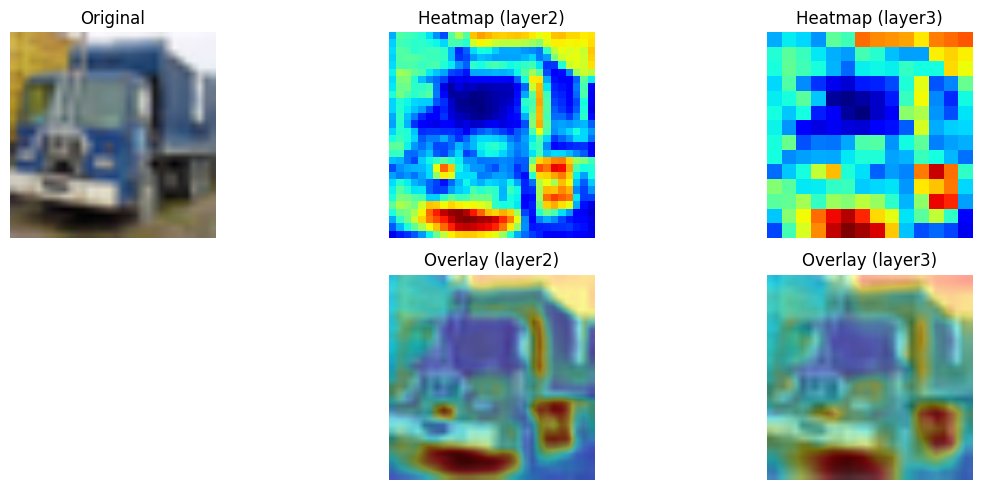

In [ ]:

model = ResNet14(num_classes=10)
model.load_state_dict(torch.load("student_r14_baseline_best.pt", map_location='cpu'))
model.eval()


transform_vis = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])
transform_original = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])


dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_vis)
original_imgs = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_original)

input_tensor, _ = dataset[14]
img_tensor_for_vis, _ = original_imgs[14]
input_tensor = input_tensor.unsqueeze(0)


with torch.no_grad():
    features, logits = model(input_tensor)
    f2 = features['layer2']
    f3 = features['layer3']


def generate_heatmap(feature):
    feature = feature.squeeze(0)
    heatmap, _ = torch.max(feature, dim=0)
    heatmap = heatmap.cpu().numpy()
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / (heatmap.max() + 1e-5)
    return heatmap

def overlay_heatmap_on_image(heatmap, original_tensor):
    image = transforms.ToPILImage()(original_tensor).convert("RGB").resize((224, 224))
    img_np = np.array(image)
    heatmap_resized = cv2.resize(heatmap, (img_np.shape[1], img_np.shape[0]))
    heatmap_color = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    overlay = cv2.addWeighted(img_np, 0.6, heatmap_color, 0.4, 0)
    return heatmap_resized, overlay


heatmaps = [generate_heatmap(f) for f in [f2, f3]]
overlays = [overlay_heatmap_on_image(h, img_tensor_for_vis)[1] for h in heatmaps]
layers = ['layer2', 'layer3']


plt.figure(figsize=(12, 5))
plt.subplot(2, len(layers) + 1, 1)
plt.title("Original")
plt.imshow(np.transpose(img_tensor_for_vis.numpy(), (1, 2, 0)))
plt.axis('off')

for i, (layer_name, heatmap, overlay) in enumerate(zip(layers, heatmaps, overlays)):
    plt.subplot(2, len(layers) + 1, i + 2)
    plt.title(f"Heatmap ({layer_name})")
    plt.imshow(heatmap, cmap='jet')
    plt.axis('off')

    plt.subplot(2, len(layers) + 1, i + 2 + len(layers) + 1)
    plt.title(f"Overlay ({layer_name})")
    plt.imshow(overlay[:, :, ::-1])
    plt.axis('off')

plt.tight_layout()
plt.show()
